<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/trial_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install pathy -q
!pip install comet_ml -q

     |████████████████████████████████| 2.0MB 6.9MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 133kB 22.8MB/s 
     |████████████████████████████████| 163kB 26.3MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 122kB 8.4MB/s 
     |████████████████████████████████| 256kB 6.9MB/s 
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 522kB 9.2MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 


In [2]:
import requests
r = requests.get('https://ipinfo.io')
r.json()

{'city': 'Council Bluffs',
 'country': 'US',
 'hostname': '244.86.70.34.bc.googleusercontent.com',
 'ip': '34.70.86.244',
 'loc': '41.2619,-95.8608',
 'org': 'AS15169 Google LLC',
 'postal': '51502',
 'readme': 'https://ipinfo.io/missingauth',
 'region': 'Iowa',
 'timezone': 'America/Chicago'}

In [3]:
# import comet_ml at the top of your file
from comet_ml import Experiment
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP


# ## Sample colab config
# args = parser.parse_args('''
# refactor_test
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -tfr
# -s GCS
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# --bucket_name iowa_bucket_lfp
# -i
# '''.split())

## Sample colab config
args = parser.parse_args('''
PB0_02
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s GCS
-d TPU
-b 16
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
-B 0.02
-i 
-tfr
-n 5
--bucket_name iowa_bucket_lfp
'''.split())

# -n 5
# -q 8

print(args)

Namespace(actor_layer_size=2048, batch_size=16, beta=0.02, bucket_name='iowa_bucket_lfp', colab=True, data_source='GCS', device='TPU', encoder_layer_size=512, fp16=False, from_tfrecords=True, gcbc=False, images=True, img_embedding_size=64, latent_dim=256, learning_rate=0.0003, num_distribs=5, planner_layer_size=2048, qbits=None, resume=False, run_name='PB0_02', test_datasets=['UR5_slow_gripper_test'], tpu_name=None, train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=200000, window_size_max=50, window_size_min=20)


## Init

In [5]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/learning_from_play'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 2549 (delta 35), reused 26 (delta 10), pack-reused 2480
Receiving objects: 100% (2549/2549), 124.57 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (1513/1513), done.
Mounted at /content/drive
No pybullet installation found - which is fine if training


Reading data from Google Cloud Storage
Storage path: gs://iowa_bucket_lfp/


In [6]:

print("Tensorflow version " + tf.__version__)

if args.device == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=args.tpu_name)  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
    if args.fp16:
        tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
        if args.fp16:
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
    strategy = tf.distribute.get_strategy()
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.88.63.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.88.63.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.88.63.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [7]:
# Use this to edit modules without needing to restart the kernel (can also edit local, push/pull)
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)
importlib.reload(lfp.metric)

Already up to date.


<module 'lfp.metric' from '/content/learning_from_play/lfp/metric.py'>

## Data

In [8]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=GLOBAL_BATCH_SIZE,  window_size=args.window_size_max, min_window_size=args.window_size_min)

In [9]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

{   'acts': TensorSpec(shape=(128, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(128, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(128, 50, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(128, 50, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(128, 50, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(128, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(128, 50, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(128, 50, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(128,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(128, None), dtype=tf.int32, name=None)}


In [10]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

{   'acts': TensorSpec(shape=(128, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(128, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(128, 50, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(128, 50, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(128, 50, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(128, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(128, 50, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(128, 50, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(128,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(128, None), dtype=tf.int32, name=None)}


# Training Loop

In [11]:
from lfp.train import LFPTrainer

def train_setup():
    model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
                'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim}

    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        model_params['layer_size'] = args.encoder_layer_size
        encoder = lfp.model.create_encoder(**model_params)
        model_params['layer_size'] = args.planner_layer_size
        planner = lfp.model.create_planner(**model_params)

    if args.images:
      cnn = lfp.model.create_vision_network(dl.img_size, dl.img_size, embedding_size=args.img_embedding_size)
    else:
      cnn = None

    #optimizer = tfa.optimizers.LAMB(learning_rate=args.learning_rate)
    optimizer = optimizer = tf.optimizers.Adam
    trainer = LFPTrainer(args, actor, dl, encoder, planner, cnn, optimizer, strategy, GLOBAL_BATCH_SIZE)
    return actor, encoder, planner, trainer


if args.device=='CPU' or args.device=='GPU':
     actor, encoder, planner, trainer = train_setup()
else:
    with strategy.scope():
         actor, encoder, planner, trainer = train_setup()
        
        


In [12]:

train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))
plotting_dataset = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset

In [13]:
# Creating these autograph wrappers so that tf.data operations are executed in graph mode
@tf.function
def train(train_dataset, beta):
    train_batch = next(train_dataset)
    trainer.distributed_train_step(train_batch, beta)
@tf.function
def sampleOnfly(train_dataset, beta):
    train_batch = next(train_dataset)

#train(train_dist_dataset, args.beta)
sampleOnfly(train_dist_dataset, args.beta)

In [14]:
from tqdm import tqdm
t = time.time()
for i in tqdm(range(0,10)):
  train(train_dist_dataset, args.beta)
  # train_batch = next(train_dist_dataset)
  # trainer.distributed_train_step(train_batch, args.beta)
print(time.time()-t)

  0%|          | 0/10 [00:08<?, ?it/s]


KeyboardInterrupt: ignored

In [16]:
from tqdm import tqdm
t = time.time()
for i in tqdm(range(0,1000)):
  sampleOnfly(train_dist_dataset, args.beta)
  # train_batch = next(train_dist_dataset)
  # trainer.distributed_train_step(train_batch, args.beta)
print(time.time()-t)

100%|██████████| 1000/1000 [00:01<00:00, 691.75it/s]

1.4487197399139404


In [18]:
data_paths = [str(STORAGE_PATH/'precompute')+f"/{x}.tfrecords" for x in range(0,4)]

In [83]:
#@title Serialise


r = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=1,  window_size=args.window_size_max, min_window_size=args.window_size_min)
rd = r.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
rd = r.load(rd)
r_it = iter(rd)
r_it.next()


@tf.function
def sample():
  return r_it.next()

sample()['seq_lens']

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def serialise(data):
    
    obs, acts, goals, seq_lens, masks, dataset_path, tstep_idxs , imgs , goal_imgs, proprioceptive_features = data['obs'], \
    data['acts'], data['goals'], data['seq_lens'], data['masks'], data['dataset_path'], data['tstep_idxs'], data['imgs'], data['goal_imgs'], data['proprioceptive_features']
    
    # obs (1, 40, 18)
    # acts (1, 40, 7)
    # goals (1, 40, 11)
    # seq_lens (1,)
    # masks (1, 40)
    # dataset_path (1, 40)
    # tstep_idxs (1, 40)
    # imgs (1, 40, 200, 200, 3)
    # goal_imgs (1, 40, 200, 200, 3)
    # proprioceptive_features (1, 40, 7)

    goal_imgs = tf.expand_dims(goal_imgs[:,0,:,:,:],1) # crete a :, 1, :,:,: shaped goal images for less file IO

    
    obs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(obs)).numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(acts)).numpy(),]))
    goals = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(goals)).numpy(),])) 
    seq_lens = Feature(int64_list=Int64List(value=[seq_lens,]))
    masks = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(masks)).numpy(),])) 

    imgs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(imgs)).numpy(),]))
    goal_imgs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(goal_imgs)).numpy(),]))
    proprioceptive_features = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(tf.squeeze(proprioceptive_features)).numpy(),]))

    
    features = Features(feature={
              'obs':obs,
              'acts':acts,
              'goals':goals,
              'seq_lens':seq_lens,
              'masks':masks,
              'imgs':imgs,
              'goal_imgs':goal_imgs,
              'proprioceptive_features':proprioceptive_features})
    
    example = Example(features=features)
    
    return example.SerializeToString()

In [84]:
#@title write to gcs

for path in data_paths:
  with tf.io.TFRecordWriter(path) as file_writer:
    print(path)
    for i in tqdm(range(0,200)):
        byte_stream = serialise(sample())
        file_writer.write(byte_stream)

  2%|▏         | 3/200 [00:00<00:08, 24.03it/s]

gs://iowa_bucket_lfp/precompute/0.tfrecords


  2%|▏         | 3/200 [00:00<00:08, 23.97it/s]

gs://iowa_bucket_lfp/precompute/1.tfrecords


  2%|▏         | 3/200 [00:00<00:08, 23.34it/s]

gs://iowa_bucket_lfp/precompute/2.tfrecords


  2%|▏         | 3/200 [00:00<00:08, 23.43it/s]

gs://iowa_bucket_lfp/precompute/3.tfrecords


100%|██████████| 200/200 [00:08<00:00, 22.64it/s]


In [ ]:
# @------title decode
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    #image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [200,200, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
            'obs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'goals':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'seq_lens':tf.io.FixedLenFeature([], tf.int64),
            'masks':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'imgs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'goal_imgs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'proprioceptive_features':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
    }
    data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    obs = tf.io.parse_tensor(data['obs'], tf.float32) 
    acts = tf.io.parse_tensor(data['acts'], tf.float32) 
    goals = tf.io.parse_tensor(data['goals'], tf.float32)  
    seq_lens = tf.cast(data['seq_lens'], tf.int32) # this is meant to be 32 even though you serialize as 64
    masks = tf.io.parse_tensor(data['masks'], tf.float32) 
    imgs = tf.io.parse_tensor(data['imgs'], tf.uint8)   
    goal_imgs = tf.io.parse_tensor(data['goal_imgs'], tf.uint8)
    goal_imgs = tf.tile(tf.expand_dims(tf.io.parse_tensor(data['goal_imgs'], tf.uint8),0), [args.window_size_max,1,1,1])   
    proprioceptive_features =tf.io.parse_tensor( data['proprioceptive_features'], tf.float32) 

    
    # img = decode_image(data['img'])

    return {  'obs':obs,
              'acts':acts,
              'goals':goals,
              'seq_lens':seq_lens,
              'masks':masks,
              'imgs':imgs,
              'goal_imgs':goal_imgs,
              'proprioceptive_features':proprioceptive_features}
              
def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=60) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=600)
    dataset =   dataset.repeat()\
                .batch(dl.batch_size, drop_remainder=True)\
                .prefetch(dl.prefetch_size)
    return dataset

d = load_tf_records(data_paths, ordered=False)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths

In [92]:
precomp_dist_dataset = iter(strategy.experimental_distribute_dataset(d))

In [96]:
precomp_dist_dataset.next().keys()

dict_keys(['obs', 'acts', 'goals', 'seq_lens', 'masks', 'imgs', 'goal_imgs', 'proprioceptive_features'])

In [104]:
for k,v in train_dist_dataset.next().items():
  print(k)

obs
acts
goals
seq_lens
masks
dataset_path
tstep_idxs
imgs
goal_imgs
proprioceptive_features


In [105]:
@tf.function
def sampleprecomp():
  train_batch = next(precomp_dist_dataset)

In [108]:
from tqdm import tqdm
t = time.time()
for i in tqdm(range(0,100)):
  # train(precomp_dist_dataset, args.beta)
  sampleprecomp()
  #trainer.distributed_train_step(train_batch, args.beta)
print(time.time()-t)


100%|██████████| 100/100 [00:00<00:00, 5201.53it/s]

0.022202491760253906


In [59]:
d = iter(d)
x = d.next()

In [60]:
t = time.time()
for i in range(0,100):
  print(i)
  x = d.next()
print(time.time()-t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


KeyboardInterrupt: ignored

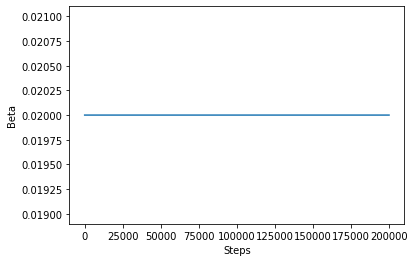

In [15]:
from lfp.train import BetaScheduler


# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=args.beta, 
                           beta_max=args.beta, 
                           max_steps=args.train_steps, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [ ]:

from tensorflow.keras.utils import Progbar
progbar = Progbar(args.train_steps, verbose=1, interval=0.5)
valid_inc = 20
save_inc = 2000
prev_grad_norm = np.float('inf')

In [ ]:
run_name = args.run_name
model_path = str(STORAGE_PATH/'saved_models'/args.run_name)

if args.resume:
  # WandB reinit
  with open(f'{model_path}/config.json', 'r') as f:
      data = json.load(f)
  # Comet ML reinit
  exp = ExistingExperiment(api_key="C4vcCM57bnSYEsdncguxDW8pO",  previous_experiment=data['experiment_key'])

  wandb.init(project="learning-from-play_v2", id=data['run_id'],  resume="must")
  t = wandb.run.step + valid_inc # Todo get this from comet to complete the transition

  load_weights(model_path, actor, encoder, planner, with_optimizer=True)
  print('Loaded model weights and optimiser state')
  
  prognar.add(t, []) # update the progbar to the most recent point
else:
  #Comet
  experiment = Experiment(api_key="C4vcCM57bnSYEsdncguxDW8pO",project_name="learning-from-play",workspace="sholtodouglas")
  experiment.set_name(run_name)
  # WandB
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sholtodouglas/learning-from-play/d7a63e86757646d8933056f8ecb3cab5



In [ ]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
from lfp.metric import log # gets state and clears simultaneously

In [ ]:
import time

In [ ]:
t = time.time()
for i in range(0,10):
  train_batch = next(train_dist_dataset)
  trainer.distributed_train_step(train_batch, args.beta)
print(time.time() - t)

5.735045909881592


In [ ]:
#

In [ ]:


# Creating these autograph wrappers so that tf.data operations are executed in graph mode
@tf.function
def train(train_dataset, beta):
    train_batch = next(train_dataset)
    trainer.distributed_train_step(train_batch, beta)

@tf.function
def test(valid_dataset, beta):
    valid_batch = next(valid_dataset)
    trainer.distributed_test_step(valid_batch, beta)

while t < args.train_steps:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    train(train_dist_dataset, beta)

    if t % valid_inc == 0:
        test(valid_dist_dataset, beta)
        step_time = round(time.time() - start_time, 1)

        metrics = {metric_name: log(metric) for metric_name, metric in trainer.metrics.items()}
        metrics['step_time'] = step_time

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']),
                                ('Validation Loss', metrics['valid_loss']),
                                ('Time (s)', step_time)])
        #Plot on Comet
        experiment.log_metrics(metrics,step=t)
        # Plot on WandB
        wandb.log(metrics, step=t)

    if (t+1) % save_inc == 0:
        trainer.save_weights(model_path, run_id=wandb.run.id, experiment_key=experiment.get_key())
        if not args.gcbc and not args.images:
          z_enc, z_plan = produce_cluster_fig(next(plotting_dataset), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)

          #Comet
          experiment.log_figure('z_enc', z_enc, step=t)
          experiment.log_figure('z_plan', z_plan,step=t)

          # WandB
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)

          #latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

    60/200000 [..............................] - ETA: 409:30:55 - Train Loss: 0.0339 - Validation Loss: 0.0255 - Time (s): 75.9667 

KeyboardInterrupt: ignored